In [18]:
from shinobi_behav import DATA_PATH



import os
import os.path as op
import pandas as pd
from nilearn import image
from shinobi_fmri.annotations.annotations import get_scrub_regressor
import numpy as np
import argparse
import shinobi_behav
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.image import clean_img
from nilearn.signal import clean
import nibabel as nib
import logging
import pickle
import nilearn
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


def get_filenames(sub: str, ses: str, run: str, path_to_data: str) -> Tuple[str, str, str, str]:
    """
    Returns file names for fMRI, anatomy and annotation events.
    Parameters
    ----------
    subject : str
        Subject id
    session : str
        Session id
    run : str
        Run number
    path_to_data : strrun: str
        Path to the data folder
    Returns
    -------
    tuple
        Tuple containing file names of fMRI, anatomy, and annotated events
    """
    fmri_fname = op.join(
        path_to_data,
        "shinobi.fmriprep",
        sub,
        ses,
        "func",
        f"{sub}_{ses}_task-shinobi_run-{run}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz",
    )
    assert op.isfile(fmri_fname), f"fMRI file not found for {sub}_{ses}_{run}"
    anat_fname = op.join(
        path_to_data,
        "cneuromod.processed",
        "smriprep",
        sub,
        "anat",
        f"{sub}_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz",
    )
    assert op.isfile(anat_fname), f"sMRI file not found for {sub}_{ses}_{run}"
    mask_fname = op.join(
        path_to_data,
        "cneuromod.processed",
        "smriprep",
        sub,
        "anat",
        f"{sub}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz",
    )
    assert op.isfile(mask_fname), f"Mask file not found for {sub}_{ses}_{run}"
    events_fname = op.join(
        path_to_data, 
        "shinobi_released",
        "shinobi", 
        sub,
        ses,
        "func",
        f"{sub}_{ses}_task-shinobi_run-0{run}_desc-annotated_events.tsv"
    )
    assert op.isfile(events_fname), f"Annotated events file not found for {sub}_{ses}_{run}" 
    return fmri_fname, anat_fname, events_fname, mask_fname

def get_output_names(sub, ses, regressor_output_name):
    """
    Constructs and returns the file paths for the GLM, z-map, and report files.

    This function constructs the file paths for the GLM (general linear model),
    z-map, and report files for a given subject, session, and regressor, using a predefined 
    directory structure and file naming convention.

    Parameters:
    sub : str
        The subject identifier.
    ses : str
        The session identifier.
    regressor_output_name : str
        The name of the regressor, used in the naming of the output files.

    Returns:
    glm_fname : str
        The file path for the GLM file.
    z_map_fname : str
        The file path for the z-map file.
    report_fname : str
        The file path for the report file.
    """
    glm_fname = op.join(shinobi_behav.DATA_PATH,
            "processed",
            "glm",
            "ses-level",
            f"{sub}_{ses}_{regressor_output_name}_simplemodel_fitted_glm.pkl")
    
    z_map_fname = op.join(
            shinobi_behav.DATA_PATH,
            "processed",
            "z_maps",
            "ses-level",
            regressor_output_name,
            f"{sub}_{ses}_simplemodel_{regressor_output_name}.nii.gz",
        )
    
    
    report_fname = op.join(
            shinobi_behav.FIG_PATH,
            "ses-level",
            regressor_output_name,
            "report",
            f"{sub}_{ses}_simplemodel_{regressor_output_name}_report.html",
        )
    return glm_fname, z_map_fname, report_fname

def load_image_and_mask(fmri_fname, mask_fname):
    """
    Load and clean 4d image and resample anat mask
    Parameters
    ----------
    fmri_fname : str
        File name of fMRI image
    anat_fname : str
        File name of anatomy image
    Returns
    -------
    tuple
        Tuple containing cleaned fMRI and resampled anatomy images
    """
    # Load and clean 4d image
    fmri_img = clean_img(
        fmri_fname,
        standardize=True,
        detrend=True,
        high_pass=None,
        t_r=t_r,
        ensure_finite=True,
        confounds=None,
    )
    # Load and resample (i.e. morph  ?) anat mask
    aff_orig = nib.load(fmri_fname).affine[:, -1]
    target_affine = np.column_stack([np.eye(4, 3) * 4, aff_orig])
    mask_resampled = image.resample_img(mask_fname, target_affine=target_affine, target_shape=fmri_img.get_fdata().shape[:3])
    return fmri_img, mask_resampled

def get_clean_matrix(fmri_fname, fmri_img, annotation_events, run_events):
    """
    Load confounds, create design matrix and return a cleaned matrix
    Parameters
    ----------
    fmri_fname : str
        File name of fMRI image
    fmri_img : nifti-image
        Cleaned fMRI image
    annotation_events : dataframe
        Dataframe containing annotation events
    run_events : dataframe
        Dataframe containing run events
    Returns
    -------
    matrix
        Design matrix after cleaning
    """
    # Load confounds
    confounds = nilearn.interfaces.fmriprep.load_confounds(fmri_fname, strategy=('motion', 'high_pass', 'wm_csf'), 
                                                           motion='full', wm_csf='basic', global_signal='full')

    # Generate design matrix
    bold_shape = fmri_img.shape
    n_slices = bold_shape[-1]
    frame_times = np.arange(n_slices) * t_r
    design_matrix_raw = make_first_level_design_matrix(
        frame_times,
        events=annotation_events,
        drift_model=None,
        hrf_model=hrf_model,
        add_regs=confounds[0],
        add_reg_names=confounds[0].keys(),
    )

    # Clean regressors ## Virer detrend, essayer avec/sans standardize, utiliser add regs pour ajouter les levels
    regressors_clean = clean(
        design_matrix_raw.to_numpy(),
        detrend=True,
        standardize=True,
        high_pass=None,
        t_r=t_r,
        ensure_finite=True,
        confounds=None,
    )

    # Recombine design_matrix (restoring constant after cleaning and adding scrub regressors)
    design_matrix_clean = pd.DataFrame(
        regressors_clean, columns=design_matrix_raw.columns.to_list()
    )
    #design_matrix_clean["constant"] = 1
    design_matrix_clean = get_scrub_regressor(run_events, design_matrix_raw)
    return design_matrix_clean

def make_and_fit_glm(fmri_imgs, design_matrices, mask_resampled):
    """
    Perform GLM analysis and threshold the results
    Parameters
    ----------
    fmri_img : nifti-image
        Cleaned fMRI image
    mask_resampled : nifti-image
        Resampled mask
    cleaned_matrix : pandas.DataFrame
        Design matrix after cleaning
    Returns
    -------
    None
    """
    fmri_glm = FirstLevelModel(
        t_r=t_r,
        noise_model="ar1",
        standardize=False,
        hrf_model=hrf_model,
        drift_model=None,
        high_pass=None,
        n_jobs=16,
        smoothing_fwhm=5,
        mask_img=mask_resampled,
        minimize_memory=False,
    )
    fmri_glm = fmri_glm.fit(fmri_imgs, design_matrices=design_matrices)
    return fmri_glm

def make_z_map(z_map_fname, report_fname, fmri_glm, regressor_name):
    """
    Creates or loads a z-score map for a given GLM and regressor.

    This function creates the z-score map for a given GLM and regressor, 
    then saves the map to a file and generates a report. If the z-score 
    map file already exists, it skips the creation process.

    Parameters:
    z_map_fname : str
        The name of the file to save the z-score map.
    report_fname : str
        The name of the file to save the report.
    fmri_glm : nistats.regression.FirstLevelModel
        The GLM to use for creating the z-score map.
    regressor_name : str
        The name of the regressor for which to create the z-score map.

    Returns:
    None
    """
    if not (os.path.exists(z_map_fname)):
        print(f"Z map not found, computing : {z_map_fname}")
        # Get Z_map
        z_map = fmri_glm.compute_contrast(
                    regressor_name, output_type="z_score", stat_type="F"
                )
        os.makedirs(op.join(path_to_data, "processed", "z_maps", "ses-level", regressor_name), exist_ok=True)
        z_map.to_filename(z_map_fname)

        # Get report
        os.makedirs(op.join(figures_path, "ses-level", regressor_name, "report"), exist_ok=True)
        report = fmri_glm.generate_report(contrasts=[regressor_name])
        report.save_as_html(report_fname)
    else:
        print(f"Z map found, skipping : {z_map_fname}")
    #return z_map

def select_events(run_events):
    """
    Selects and prepares event data for a given run.

    This function filters the events of a run based on a predefined list 
    of conditions, prepares the event data for analysis, and returns it.

    Parameters:
    run_events : pandas.DataFrame
        The event data for a given run.

    Returns:
    annotation_events : pandas.DataFrame
        The prepared event data.
    """
    # Select events
    annotation_events = run_events[run_events["trial_type"].isin(CONDS_LIST)]
    annotation_events = annotation_events[["trial_type", "onset", "duration"]]

    replevel_events = run_events[run_events["trial_type"]=="gym-retro_game"]
    replevel_events["trial_type"] = replevel_events["level"]
    replevel_events = replevel_events.replace({"trial_type": {"level-1": "lvl1", "level-4": "lvl4", "level-5": "lvl5"}})
    replevel_events = replevel_events[["trial_type", "onset", "duration"]]
    annotation_events = pd.concat((annotation_events, replevel_events), axis=0)
    return annotation_events

def load_run(fmri_fname, mask_fname, events_fname):
    """
    Loads and prepares the data for a given run.

    This function loads the image data, event data, and mask for a given 
    run, prepares the event data, and generates a clean design matrix. 

    Parameters:
    fmri_fname : str
        The file name of the fMRI image data.
    mask_fname : str
        The file name of the mask.
    events_fname : str
        The file name of the event data.

    Returns:
    design_matrix_clean : pandas.DataFrame
        The clean design matrix.
    fmri_img : nibabel.Nifti1Image
        The loaded fMRI image data.
    mask_resampled : nibabel.Nifti1Image
        The loaded mask.
    """
    # Load events
    run_events = pd.read_csv(events_fname, sep="\t", index_col=[0])
    annotation_events = select_events(run_events)

    # Load images
    fmri_img, mask_resampled = load_image_and_mask(fmri_fname, mask_fname)
    
    # Make design matrix
    design_matrix_clean = get_clean_matrix(fmri_fname, fmri_img, annotation_events, run_events)
    return design_matrix_clean, fmri_img, mask_resampled

def load_session(sub, ses, run_list, path_to_data):
    """
    Loads and prepares the data for a given session.

    This function loads and prepares the image data, event data, and mask 
    for each run in a given session.

    Parameters:
    sub : str
        The subject identifier.
    ses : str
        The session identifier.
    run_list : list
        The list of runs to load.
    path_to_data : str
        The path to the data.

    Returns:
    fmri_imgs : list of nibabel.Nifti1Image
        The loaded fMRI image data for each run.
    design_matrices : list of pandas.DataFrame
        The clean design matrix for each run.
    mask_resampled : nibabel.Nifti1Image
        The loaded mask.
    anat_fname : str
        The file name of the anatomical image.
    """
    design_matrices = []
    fmri_imgs = []
    for run in run_list:
        fmri_fname, anat_fname, events_fname, mask_fname = get_filenames(sub, ses, run, path_to_data)
        print(f"Loading : {fmri_fname}")
        design_matrix_clean, fmri_img, mask_resampled = load_run(fmri_fname, mask_fname, events_fname)
        design_matrices.append(design_matrix_clean)
        fmri_imgs.append(fmri_img)
    return fmri_imgs, design_matrices, mask_resampled, anat_fname

def remove_runs_without_target_regressor(regressor_names, fmri_imgs, trimmed_design_matrices):
    """
    Removes runs that do not contain all target regressors.

    This function filters out the runs that do not contain all target 
    regressors in their design matrix.

    Parameters:
    regressor_names : list of str
        The names of the target regressors.
    fmri_imgs : list of nibabel.Nifti1Image
        The fMRI images for each run.
    trimmed_design_matrices : list of pandas.DataFrame
        The design matrices for each run.

    Returns:
    images_copy : list of nibabel.Nifti1Image
        The fMRI images for the runs that contain all target regressors.
    dataframes_copy : list of pandas.DataFrame
        The design matrices for the runs that contain all target regressors.
    """
    images_copy = fmri_imgs.copy()
    dataframes_copy = trimmed_design_matrices.copy()
    for img, df in zip(fmri_imgs, trimmed_design_matrices):
        for reg in regressor_names:
            if reg not in df.columns:
                images_copy.remove(img)
                dataframes_copy.remove(df)
            
    return images_copy, dataframes_copy

def trim_design_matrices(design_matrices, regressor_name):
    """
    This function removes unwanted regressors from the design matrix for each run. 

    Parameters
    ----------
    design_matrices : list
        A list of pandas DataFrames containing the design matrices for each run.
    regressor_name : str
        The name of the regressor that should not be removed.

    Returns
    -------
    list
        A list of trimmed design matrices for each run.
    """
    # Copy the list of conditions and levels to create a list of regressors to remove
    regressors_to_remove = CONDS_LIST.copy()
    # We don't want to remove the current regressor of interest, so remove it from the list of regressors to remove
    if not 'lvl' in regressor_name:
        regressors_to_remove.remove(regressor_name)

    trimmed_design_matrices = []
    # For each design matrix, remove the unwanted regressors
    for design_matrix in design_matrices:
        trimmed_design_matrix = design_matrix
        for reg in regressors_to_remove:
            try:
                # Try to drop the current regressor from the design matrix
                trimmed_design_matrix = trimmed_design_matrix.drop(columns=reg)
            except Exception as e:
                print(e)
                print(f"Regressor {reg} might be missing ?")
        # Append the trimmed design matrix to the list of trimmed design matrices
        trimmed_design_matrices.append(trimmed_design_matrix)
    return trimmed_design_matrices

def make_or_load_glm(sub, ses, run_list, glm_regressors, glm_fname):
    """
    Creates a General Linear Model (GLM) if it doesn't already exist, or loads it from disk if it does.

    This function uses the provided list of regressors to create the GLM. It first checks if the specified 
    GLM file already exists. If it does, the function loads and returns the GLM. If not, the function creates
    the GLM. 

    If image and design matrix data have been previously loaded and saved to global variables, the function
    uses this data to create the GLM, thereby avoiding reloading all the data. Once the GLM has been created,
    it's dumped to the specified file for future use.

    Parameters:
    sub : str
        Subject identifier.
    ses : str
        Session identifier.
    run_list : list
        List of runs to consider.
    glm_regressors : list
        List of regressors to consider when creating the GLM.
    glm_fname : str
        The name of the file to which the GLM will be dumped, or from which it will be loaded.

    Returns:
    fmri_glm : nistats.regression.FirstLevelModel
        The GLM, either loaded from disk or newly created.
    """
    global fmri_imgs_copy, design_matrices_copy, mask_resampled
    if not (os.path.exists(glm_fname)):
        # Avoid reloading all the data if it is already loaded
        if fmri_imgs_copy is None:
            fmri_imgs, design_matrices, mask_resampled, anat_fname = load_session(sub, ses, run_list, path_to_data)
            fmri_imgs_copy = fmri_imgs.copy()
            design_matrices_copy = design_matrices.copy()
        else:
            fmri_imgs = fmri_imgs_copy.copy()
            design_matrices = design_matrices_copy.copy()

        print(f"GLM not found, computing : {glm_fname}")
        print(glm_regressors)
        trimmed_design_matrices = trim_design_matrices(design_matrices, glm_regressors[0])
        fmri_imgs, trimmed_design_matrices = remove_runs_without_target_regressor(glm_regressors, fmri_imgs, trimmed_design_matrices)
        if len(glm_regressors) == 2:
            for dm in trimmed_design_matrices:
                dm.eval(f"{glm_regressors[0]}X{glm_regressors[1]} = {glm_regressors[0]} * {glm_regressors[1]}", inplace=True)
        fmri_glm = make_and_fit_glm(fmri_imgs, trimmed_design_matrices, mask_resampled)
        with open(glm_fname, "wb") as f:
            pickle.dump(fmri_glm, f, protocol=4)
    else:
        with open(glm_fname, "rb") as f:
            print(f"GLM found, loading : {glm_fname}")
            fmri_glm = pickle.load(f)
            print("Loaded.")
    return fmri_glm

def process_ses(sub, ses, path_to_data):
    """
    Process an fMRI session for a given subject and session.
    It runs General Linear Models (GLM) for different regressors, creating them if they don't already exist.

    Parameters:
    sub : str
        Subject identifier.
    ses : str
        Session identifier.
    path_to_data : str
        Path to the data directory.

    Returns:
    None
    """
    global fmri_imgs_copy, design_matrices_copy
    fmri_imgs_copy = None
    design_matrices_copy = None

    def process_regressor(regressor_name, lvl=None):
        global fmri_imgs_copy, design_matrices_copy
        if lvl is None:
            glm_regressors = [regressor_name]
            regressor_output_name = regressor_name
        else:
            glm_regressors = [regressor_name] + [lvl]
            regressor_output_name = f"{regressor_name}X{lvl}"
        glm_regressors = [regressor_name] if lvl is None else [regressor_name] + [lvl]

        print(f"Simple model of : {regressor_output_name}")
        glm_fname, z_map_fname, report_fname = get_output_names(sub, ses, regressor_output_name)
        if not (os.path.exists(z_map_fname)):
            fmri_glm = make_or_load_glm(sub, ses, run_list, glm_regressors, glm_fname)
            make_z_map(z_map_fname, report_fname, fmri_glm, regressor_output_name)
        else:
            print(f"Z map found, skipping : {z_map_fname}")

    ses_fpath = op.join(path_to_data,"shinobi.fmriprep",sub,ses,"func")
    ses_files = os.listdir(ses_fpath)
    run_files = [x for x in ses_files if "space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz" in x]
    run_list = [x[32] for x in run_files]

    # Make a GLM with each regressor separately (simple models)
    for regressor_name in CONDS_LIST+LEVELS:
        process_regressor(regressor_name)

    # Still simple models but split by level (interaction annotation X level)
    for lvl in LEVELS:
        for regressor_name in CONDS_LIST:
            process_regressor(regressor_name, lvl)
    return

def select_events(run_events):
    """
    Selects and prepares event data for a given run.

    This function filters the events of a run based on a predefined list 
    of conditions, prepares the event data for analysis, and returns it.

    Parameters:
    run_events : pandas.DataFrame
        The event data for a given run.

    Returns:
    annotation_events : pandas.DataFrame
        The prepared event data.
    """
    # Select events
    annotation_events = run_events[run_events["trial_type"].isin(CONDS_LIST)]
    annotation_events = annotation_events[["trial_type", "onset", "duration"]]

    replevel_events = run_events[run_events["trial_type"]=="gym-retro_game"]
    replevel_events["trial_type"] = replevel_events["level"]
    replevel_events = replevel_events.replace({"trial_type": {"level-1": "lvl1", "level-4": "lvl4", "level-5": "lvl5"}})
    replevel_events = replevel_events[["trial_type", "onset", "duration"]]
    annotation_events = pd.concat((annotation_events, replevel_events), axis=0)
    return annotation_events

In [8]:
fmri_fname, anat_fname, events_fname, mask_fname = get_filenames("sub-06", "ses-011", "1", path_to_data=DATA_PATH)
t_r = 1.49

fmri_img, mask_resampled = load_image_and_mask(fmri_fname, mask_fname)

In [19]:
run_events = pd.read_csv(events_fname, sep="\t", index_col=[0])
annotation_events = select_events(run_events)

In [57]:
# Load confounds
confounds = nilearn.interfaces.fmriprep.load_confounds(fmri_fname, strategy=('motion', 'high_pass', 'wm_csf'), 
                                                       motion='full', wm_csf='basic', global_signal='full')

# Generate design matrix
bold_shape = fmri_img.shape
n_slices = bold_shape[-1]
frame_times = np.arange(n_slices) * t_r
design_matrix_raw = make_first_level_design_matrix(
    frame_times,
    events=annotation_events,
    drift_model=None,
    hrf_model=hrf_model,
    add_regs=confounds[0],
    add_reg_names=confounds[0].keys(),
)

# Clean regressors ## Virer detrend, essayer avec/sans standardize, utiliser add regs pour ajouter les levels
regressors_clean = clean(
    design_matrix_raw.to_numpy(),
    detrend=True,
    standardize=True,
    high_pass=None,
    t_r=t_r,
    ensure_finite=True,
    confounds=None,
)

# Recombine design_matrix (restoring constant after cleaning and adding scrub regressors)
design_matrix_clean = pd.DataFrame(
    regressors_clean, columns=design_matrix_raw.columns.to_list()
)
#design_matrix_clean["constant"] = 1
design_matrix2 = design_matrix_clean.copy()
#design_matrix_clean = get_scrub_regressor(run_events, design_matrix_raw)

In [31]:
bold_shape = fmri_img.shape
n_slices = bold_shape[-1]
frame_times = np.arange(n_slices) * t_r
design_matrix_raw = make_first_level_design_matrix(
    frame_times,
    events=annotation_events,
    drift_model=None,
    hrf_model=hrf_model,
    add_regs=confounds[0],
    add_reg_names=confounds[0].keys(),
)

design_matrix = design_matrix_raw.copy()

In [60]:
reps = []
# Get repetition segments
for i in range(len(run_events)):
    if run_events['trial_type'][i] == "gym-retro_game":
        reps.append(run_events.iloc[i,:])

# Get time vector
time = np.array(design_matrix_raw.index)

to_keep = np.zeros(len(time))
# Generate binary regressor
for i in range(len(time)):
    for rep in reps:
        if type(rep["stim_file"]) == str and rep["stim_file"] != "Missing file" and type(rep["stim_file"]) != float:
            if time[i] >= rep['onset'] and time[i] <= rep['onset'] + rep['duration']:
                to_keep[i] = 1.0

scrub_idx = 1
for idx, timepoint in enumerate(to_keep):
    if timepoint == 0.0: # If to_keep is zero create a scrub regressor to remove this frame
        scrub_regressor = np.zeros(len(time))
        scrub_regressor[idx] = 1.0
        design_matrix_raw[f'scrub{scrub_idx}'] = scrub_regressor
        scrub_idx += 1

<AxesSubplot:label='conditions', ylabel='scan number'>

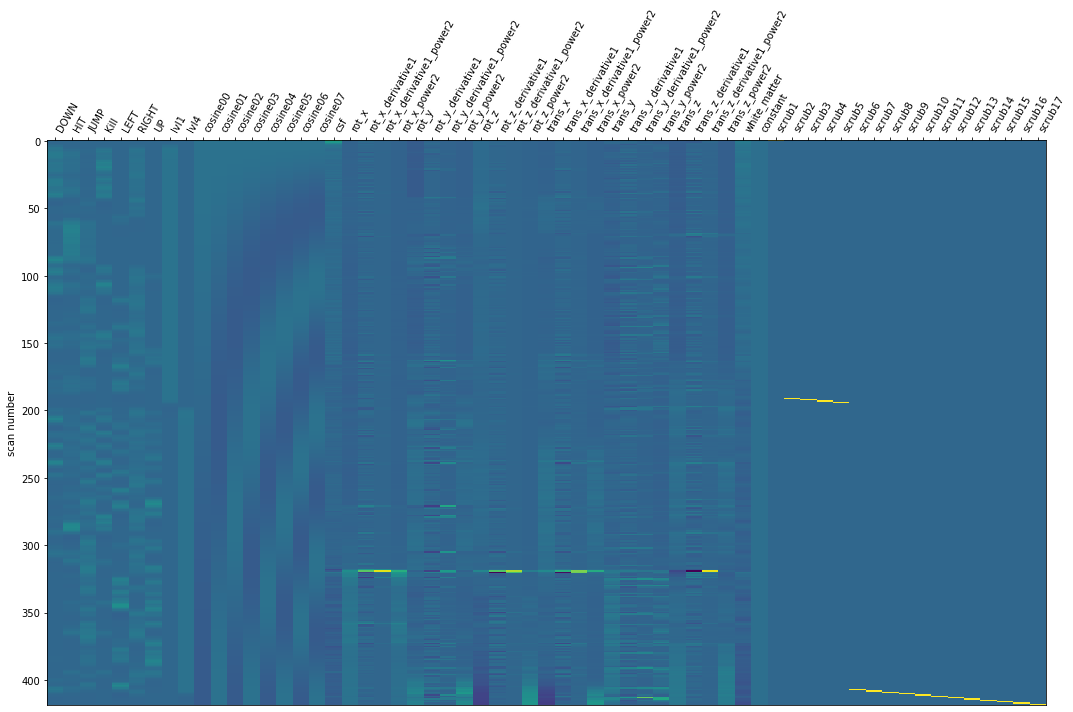

In [61]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrix_raw)

[  0.     1.49   2.98   4.47   5.96   7.45   8.94  10.43  11.92  13.41
  14.9   16.39  17.88  19.37  20.86  22.35  23.84  25.33  26.82  28.31
  29.8   31.29  32.78  34.27  35.76  37.25  38.74  40.23  41.72  43.21
  44.7   46.19  47.68  49.17  50.66  52.15  53.64  55.13  56.62  58.11
  59.6   61.09  62.58  64.07  65.56  67.05  68.54  70.03  71.52  73.01
  74.5   75.99  77.48  78.97  80.46  81.95  83.44  84.93  86.42  87.91
  89.4   90.89  92.38  93.87  95.36  96.85  98.34  99.83 101.32 102.81
 104.3  105.79 107.28 108.77 110.26 111.75 113.24 114.73 116.22 117.71
 119.2  120.69 122.18 123.67 125.16 126.65 128.14 129.63 131.12 132.61
 134.1  135.59 137.08 138.57 140.06 141.55 143.04 144.53 146.02 147.51
 149.   150.49 151.98 153.47 154.96 156.45 157.94 159.43 160.92 162.41
 163.9  165.39 166.88 168.37 169.86 171.35 172.84 174.33 175.82 177.31
 178.8  180.29 181.78 183.27 184.76 186.25 187.74 189.23 190.72 192.21
 193.7  195.19 196.68 198.17 199.66 201.15 202.64 204.13 205.62 207.11
 208.6

In [59]:
time = np.array(design_matrix_raw.index)
print(time)

[  0.     1.49   2.98   4.47   5.96   7.45   8.94  10.43  11.92  13.41
  14.9   16.39  17.88  19.37  20.86  22.35  23.84  25.33  26.82  28.31
  29.8   31.29  32.78  34.27  35.76  37.25  38.74  40.23  41.72  43.21
  44.7   46.19  47.68  49.17  50.66  52.15  53.64  55.13  56.62  58.11
  59.6   61.09  62.58  64.07  65.56  67.05  68.54  70.03  71.52  73.01
  74.5   75.99  77.48  78.97  80.46  81.95  83.44  84.93  86.42  87.91
  89.4   90.89  92.38  93.87  95.36  96.85  98.34  99.83 101.32 102.81
 104.3  105.79 107.28 108.77 110.26 111.75 113.24 114.73 116.22 117.71
 119.2  120.69 122.18 123.67 125.16 126.65 128.14 129.63 131.12 132.61
 134.1  135.59 137.08 138.57 140.06 141.55 143.04 144.53 146.02 147.51
 149.   150.49 151.98 153.47 154.96 156.45 157.94 159.43 160.92 162.41
 163.9  165.39 166.88 168.37 169.86 171.35 172.84 174.33 175.82 177.31
 178.8  180.29 181.78 183.27 184.76 186.25 187.74 189.23 190.72 192.21
 193.7  195.19 196.68 198.17 199.66 201.15 202.64 204.13 205.62 207.11
 208.6

In [50]:
418*1.49

622.82